In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import normaltest
import scipy.stats as stats
from matplotlib import pyplot as plt
import pingouin as pg


sns.set(rc={'figure.figsize':(25,10)})

In [30]:
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}
genotype_dict = {"dicer_KO": "KO", "dicer_overexpressed": "OE", "wild_type": "WT", "dicer_ko": "KO", "dicer_over_expressing": "OE"}
passage_dict = {"passage_1": "P1", "passage_5": "P5", "passage_10": "P10"}
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}

genotype_order = ["WT", "KO", "OE"]
passage_order = ['P1','P5','P10']

### plot nucleotide diversity across genome, for coding and non-coding regions

Values were computed with SNPGenie (https://github.com/chasewnelson/SNPGenie). 

In [31]:
# import data

df_WT = pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_population_summary.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_population_summary.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_population_summary.csv')


df_pop = pd.concat([df_WT, df_KO, df_OE])

df_pop["genotype"] = df_pop["genotype"].apply(lambda x: genotype_dict[x])
df_pop["passage"] = df_pop["passage"].apply(lambda x: passage_dict[x])

In [32]:
# total number of sites: 9264
# number of coding sites: 7980
# number of non-coding sites: 1284

In [33]:
df_pop["pi_fullgenome"] = df_pop['pi']

df_pop = df_pop[['pi_fullgenome',
                 'pi_coding', 
                 'pi_noncoding', 
                 'genotype',
                 'replicate', 
                 'passage']]


df_pop_long = pd.wide_to_long(df_pop, stubnames="pi", 
                              sep="_", 
                              i = ['genotype','replicate','passage'], 
                              j='measure',
                              suffix=r'\w+')
df_pop_long = df_pop_long.reset_index()

Text(0.5, 1.0, 'Full genome')

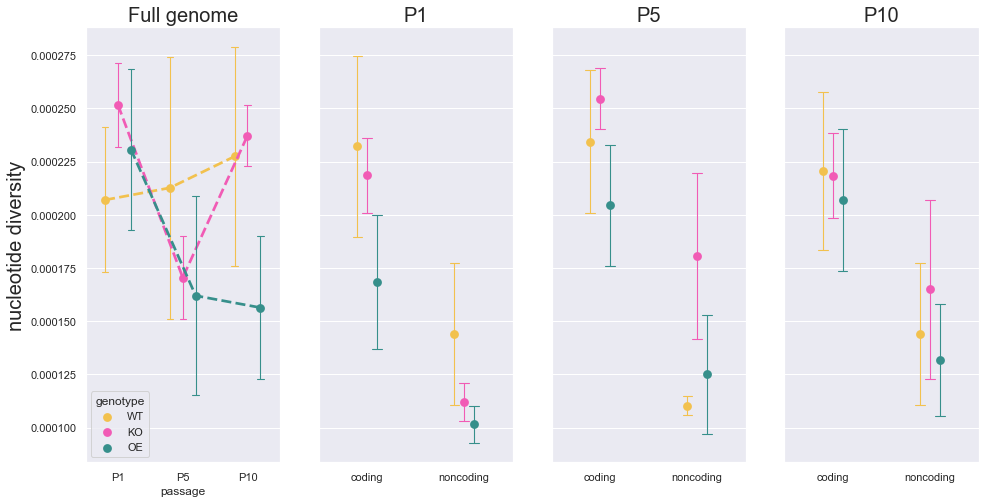

In [35]:
fig, ax = plt.subplots(1,4,  sharey=True, figsize=(16,8))

sns.pointplot(
        ax=ax[0],
        data=df_pop_long[df_pop_long['measure']=="fullgenome"], 
        markers='o', 
        linestyles='--',
        x="passage", 
        y='pi', 
        hue ='genotype', 
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        order=passage_order, 
        dodge=0.4,
    )

for idx, passage in enumerate(passage_order): 
    sns.pointplot(
        ax= ax[idx+1],
        data=df_pop_long[(df_pop_long['measure']!="fullgenome") & (df_pop_long['passage']!=passage)], 
        #kind='point', 
        markers='o', 
        linestyles='',
        x="measure", 
        y='pi', 
        hue ='genotype',
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        dodge=0.2,
    )
    ax[idx+1].set_title(passage, fontsize=20)
    ax[idx+1].set_ylabel("")
    ax[idx+1].set_xlabel("")
    ax[idx+1].get_legend().remove()
    
ax[0].set_ylabel("nucleotide diversity", fontsize=20)
ax[0].set_title("Full genome", fontsize=20)


In [17]:
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3A_nucleotide_diversity.pdf")
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3A_nucleotide_diversity.svg")

### mixed ANOVA for nulceotide diversity (full genome)

<AxesSubplot: xlabel='passage', ylabel='pi'>

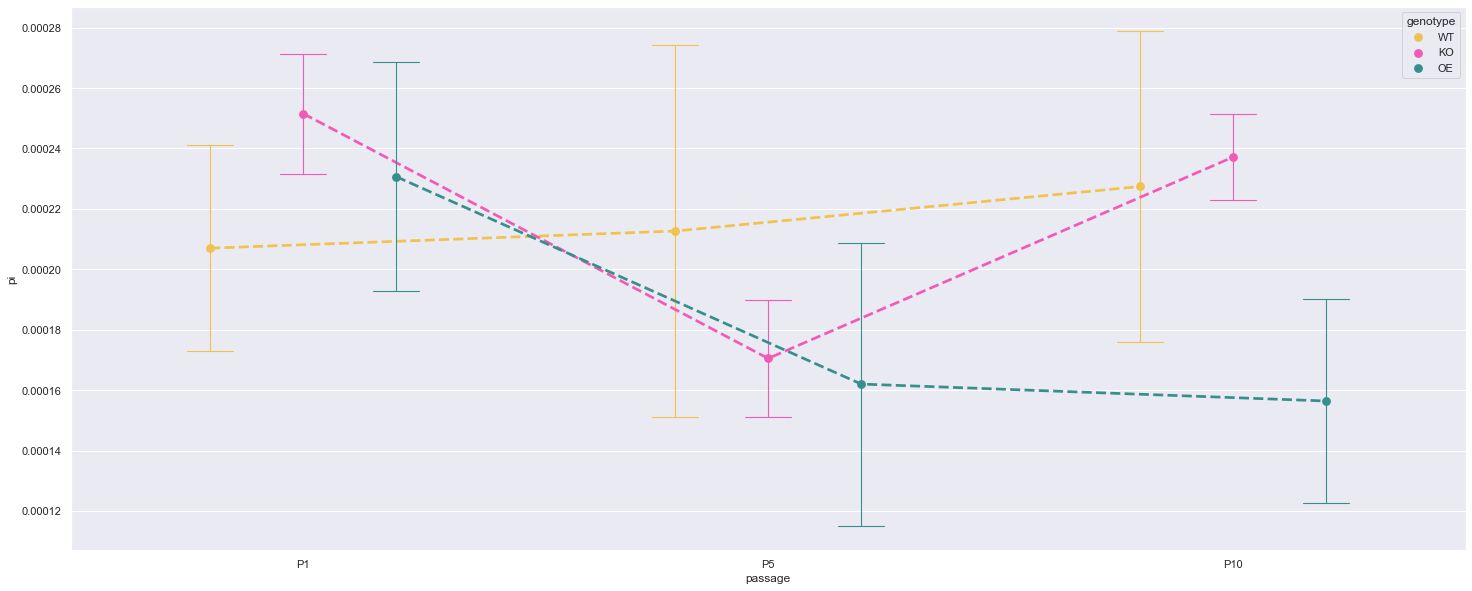

In [36]:
sns.pointplot(
        data=df_pop_long[df_pop_long['measure']=="fullgenome"], 
        markers='o', 
        linestyles='--',
        x="passage", 
        y='pi', 
        hue ='genotype', 
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        order=passage_order, 
        dodge=0.4,
    )

In [37]:
df_pop_long['factor_comb']=df_pop_long["genotype"] + '-'+df_pop_long["passage"]
df_pop_long["pi_log"] = np.log(df_pop_long["pi"])
pg.homoscedasticity(df_pop_long[df_pop_long['measure']=="fullgenome"], dv="pi", group="factor_comb")

,W,pval,equal_var
levene,1.184715,0.335111,True


In [38]:
pg.normality(df_pop_long[df_pop_long['measure']=="fullgenome"], dv='pi', group='factor_comb')

,W,pval,normal
factor_comb,,,
WT-P10,0.917235,0.512259,True
WT-P1,0.919468,0.526512,True
WT-P5,0.911354,0.475769,True
KO-P10,0.844438,0.177567,True
KO-P5,0.946735,0.713856,True
KO-P1,0.934204,0.625302,True
OE-P1,0.916823,0.509658,True
OE-P10,0.781582,0.056869,True
OE-P5,0.819328,0.115380,True


In [39]:
df_pop_long['id'] = df_pop_long['genotype'] + df_pop_long['replicate']

res = pg.mixed_anova(dv='pi', 
                  within='passage', 
                  between='genotype',
                  subject='id', 
                  data=df_pop_long[(df_pop_long['measure']=="fullgenome")], 
                 )

res

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,1.215305e-08,2,12,6.076523e-09,0.599485,0.564739,0.090838,NaN
1,passage,1.730538e-08,2,24,8.652692e-09,1.435875,0.257622,0.106869,0.757423
2,Interaction,1.960888e-08,4,24,4.902219e-09,0.813501,0.529015,0.119395,NaN


###  compare nulceotide diversity between coding and noncoding

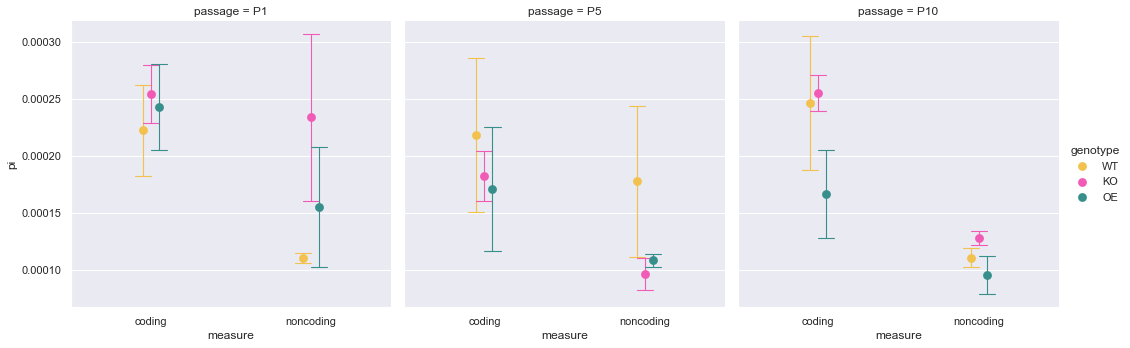

In [40]:

sns.catplot(
        data=df_pop_long[df_pop_long['measure']!="fullgenome"], 
        kind='point', 
        markers='o', 
        linestyles='',
        x="measure", 
        y='pi', 
        hue ='genotype',
        col='passage',
        errorbar="se",
        hue_order=genotype_order, 
        errwidth=1.1, 
        capsize=0.1,
        palette=our_color_palette,
        col_order=passage_order, 
        dodge=0.1,
    )

In [42]:
df_pop_long_mean = df_pop_long[(df_pop_long['measure']!="fullgenome")].pivot_table(values='pi', 
                                           index=['measure', 'genotype', 'passage'],
                                           aggfunc='mean').reset_index()

df_pop_long_mean['id'] = df_pop_long_mean['genotype'] + df_pop_long_mean['measure']

In [43]:
df_pop_long['factor_comb']=df_pop_long["measure"] + '-'+df_pop_long["passage"]
pg.homoscedasticity(df_pop_long, dv="pi", group="factor_comb")

,W,pval,equal_var
levene,1.41226,0.197539,True


In [46]:
pg.normality(df_pop_long, dv='pi', group='factor_comb')

,W,pval,normal
factor_comb,,,
fullgenome-P10,0.925351,0.232294,True
coding-P10,0.919299,0.187950,True
noncoding-P10,0.969704,0.853648,True
fullgenome-P1,0.970233,0.861497,True
coding-P1,0.951825,0.553643,True
noncoding-P1,0.676852,0.000142,False
fullgenome-P5,0.881680,0.050267,True
coding-P5,0.889357,0.065575,True
noncoding-P5,0.489395,0.000003,False


In [15]:
res = pg.mixed_anova(dv='pi', 
                     within='passage', 
                     between='measure',
                     subject='id', 
                     data=df_pop_long_mean, 
                 )

res

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,measure,3.075592e-08,1,4,3.075592e-08,28.404042,0.005967,0.876559,NaN
1,passage,6.688397e-09,2,8,3.344199e-09,1.859396,0.217184,0.317336,0.803742
2,Interaction,1.931041e-09,2,8,9.655204e-10,0.536836,0.604265,0.118328,NaN
